<a href="https://colab.research.google.com/github/neochiai555/recomendacao_imagens/blob/main/trabalho_06_recomendacao_imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
!pip install Pillow imagehash

In [84]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras
import gc

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

from PIL import Image
import imagehash

In [85]:
!echo "Downloading dataset"
!wget -O produtos.zip 'https://drive.google.com/uc?export=download&id=1at_D25j_UXs6xb36ROSlrv7ivAuSqEsw'
!unzip produtos.zip -d /content
!rm produtos.zip
!ls


--2025-01-08 23:32:50--  https://drive.google.com/uc?export=download&id=1at_D25j_UXs6xb36ROSlrv7ivAuSqEsw
Resolving drive.google.com (drive.google.com)... 142.250.101.113, 142.250.101.138, 142.250.101.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.101.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1at_D25j_UXs6xb36ROSlrv7ivAuSqEsw&export=download [following]
--2025-01-08 23:32:50--  https://drive.usercontent.google.com/download?id=1at_D25j_UXs6xb36ROSlrv7ivAuSqEsw&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 665995 (650K) [application/octet-stream]
Saving to: ‘produtos.zip’

produtos.zip        100%[===================>] 650.39K  --.-KB/s 

In [86]:
root = 'produtos'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories]

print(categories)

['produtos/bone', 'produtos/tenis', 'produtos/celular', 'produtos/carro']


Função para carregar a imagem em um objeto de imagem e um vetor.

In [87]:
# helper function to load image and return it and input vector
gc.collect()
def get_image(path):
  try:
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x
  except:
    return None, None

Carregar todas as imagens da pasta raiz.

In [88]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for i, img_path in enumerate(images):
      print(img_path)
      if i > 2000:
        break
      img, x = get_image(img_path)
      if img is not None:
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

produtos/bone/01.jpg
produtos/bone/12.jpg
produtos/bone/24.jpg
produtos/bone/26.jpg
produtos/bone/30.jpg
produtos/bone/28.jpg
produtos/bone/10.jpg
produtos/bone/18.jpg
produtos/bone/13.jpg
produtos/bone/20.jpg
produtos/bone/06.jpg
produtos/bone/08.jpg
produtos/bone/11.jpg
produtos/bone/19.jpg
produtos/bone/04.jpg
produtos/bone/29.jpg
produtos/bone/16.jpg
produtos/bone/15.jpg
produtos/bone/25.jpg
produtos/bone/07.jpg
produtos/bone/05.jpg
produtos/bone/02.jpg
produtos/bone/23.jpg
produtos/bone/09.jpg
produtos/bone/03.jpg
produtos/bone/17.jpg
produtos/bone/27.jpg
produtos/bone/22.jpg
produtos/bone/14.jpg
produtos/bone/21.jpg
produtos/tenis/01.jpg
produtos/tenis/12.jpg
produtos/tenis/24.jpg
produtos/tenis/26.jpg
produtos/tenis/30.jpg
produtos/tenis/28.jpg
produtos/tenis/10.jpg
produtos/tenis/18.jpg
produtos/tenis/13.jpg
produtos/tenis/20.jpg
produtos/tenis/06.jpg
produtos/tenis/08.jpg
produtos/tenis/11.jpg
produtos/tenis/19.jpg
produtos/tenis/04.jpg
produtos/tenis/29.jpg
produtos/tenis/16.

Randomizar a ordem dos dados.

In [89]:
random.shuffle(data)

Dividir os dado em treinamento / validação / teste (70%, 15%, 15%)

In [90]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separar os dados por labels.

In [91]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 1, 2, 3, 2, 3, 2, 2, 1, 2, 0, 2, 0, 1, 2, 0, 0, 3]


Preprocessar os dados para assegurar que são float32 e normalizados entre 0 e 1.

In [92]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(18, 4)


Sumário do resultado até aqui:

In [93]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 120 images from 4 categories
train / validation / test split: 84, 18, 18
training data shape:  (84, 224, 224, 3)
training labels shape:  (84, 4)


Vamos agora visualizar alguns dados do nosso dataset.

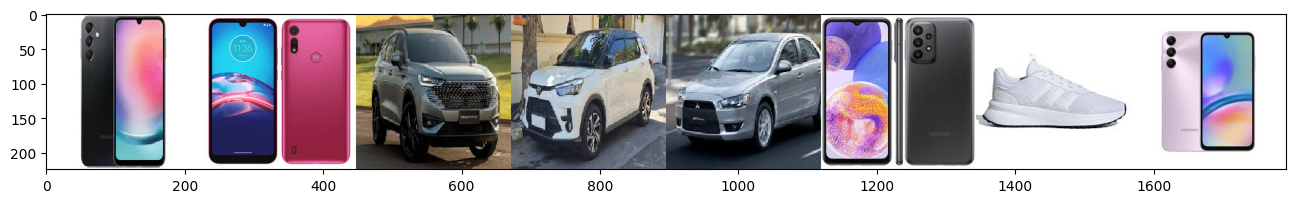

In [94]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Primeiramente vamos criar e treinar uma rede neural do zero.

In [95]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,572 (4.61 MB)

 Trainable params: 1,209,572 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Agora vamos treinar o modelo com 10 épocas e um tamanho de batch de 128, e guardar o histórico para uo posterior.

In [96]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2619 - loss: 1.3861 - val_accuracy: 0.0556 - val_loss: 1.3707
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step - accuracy: 0.3452 - loss: 1.3131 - val_accuracy: 0.4444 - val_loss: 1.2859
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.4881 - loss: 1.2022 - val_accuracy: 0.7222 - val_loss: 1.1122
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6905 - loss: 1.0415 - val_accuracy: 0.8889 - val_loss: 0.8539
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7500 - loss: 0.8417 - val_accuracy: 0.9444 - val_loss: 0.6139
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7857 - loss: 0.6282 - val_accuracy: 0.8889 - val_loss: 0.4561
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8452 - loss: 0.4157 - val_accuracy: 0.9444 - val_loss: 0.3072
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8690 - loss: 0.4418 - val_accuracy: 0.9444 - val_loss: 0.

Vamos executar nosso modelo nos dados de treinamento e verificar a perda e acurácia:

In [97]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.8697950839996338
Test accuracy: 0.7222222089767456


Nossa acurácia foi de 72%, muito bom para os dados que usamos. Agora vamos usar o modelo VGG16 da keras, que foi treinado sobre a ImageNet.

In [98]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Agora vamos remover a primeira e a última camadas e recriá-las como novas.

In [99]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Agora vamos congelar todas camadas menos a última, e compilar o modelo:

In [100]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,276,932 (512.23 MB)

 Trainable params: 16,388 (64.02 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Em seguida vamos treinar a rede usando nossos dados.

In [101]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2976 - loss: 1.5419 - val_accuracy: 0.3333 - val_loss: 1.1610
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - accuracy: 0.2381 - loss: 1.6016 - val_accuracy: 0.6667 - val_loss: 1.0815
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step - accuracy: 0.4524 - loss: 1.5377 - val_accuracy: 0.5000 - val_loss: 0.9767
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step - accuracy: 0.3810 - loss: 1.1186 - val_accuracy: 0.1111 - val_loss: 1.1893
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step - accuracy: 0.3810 - loss: 0.9923 - val_accuracy: 0.0556 - val_loss: 1.3844
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step - accuracy: 0.3571 - loss: 1.0691 - val_accuracy: 0.2778 - val_loss: 1.1182
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step - accuracy: 0.5238 - loss: 0.8961 - val_accuracy: 0.7778 - val_loss: 0.7808
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step - accuracy: 0.9167 - loss: 0.7306 - val_accuracy: 0.8889 - val_loss: 0.

Veja que a acurácia agora está perto de 89%, muito acima da que obtivemos com a rede menor e treinada do zero.
Vamos agora plotar a perda e a acurácia.

In [102]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.5437555313110352
Test accuracy: 0.8888888955116272


Testando a rede com uma nova imagem de um carro:

In [103]:
!wget -O carro.jpg 'https://drive.google.com/uc?export=download&id=1LnBCi9gkaALU3U8HnIXhGBxL_QX-WipY'

--2025-01-08 23:38:23--  https://drive.google.com/uc?export=download&id=1LnBCi9gkaALU3U8HnIXhGBxL_QX-WipY
Resolving drive.google.com (drive.google.com)... 142.250.101.138, 142.250.101.101, 142.250.101.139, ...
Connecting to drive.google.com (drive.google.com)|142.250.101.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1LnBCi9gkaALU3U8HnIXhGBxL_QX-WipY&export=download [following]
--2025-01-08 23:38:23--  https://drive.usercontent.google.com/download?id=1LnBCi9gkaALU3U8HnIXhGBxL_QX-WipY&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7816 (7.6K) [image/jpeg]
Saving to: ‘carro.jpg’

carro.jpg           100%[===================>]   7.63K  --.-KB/s    in 0s      

202

In [105]:
img, x = get_image('carro.jpg')
probabilities = model_new.predict([x])
category = categories[np.argmax(probabilities)]
print(category)
print(probabilities)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
produtos/carro
[[2.9732040e-04 2.5322786e-04 1.2000383e-04 9.9932945e-01]]


In [106]:
def calcSimilarity(pilImg):
    # Get the average hashes of both images
    hash0 = imagehash.average_hash(pilImg)
    hash1 = imagehash.average_hash(Image.open('/content/' + category + '/01.jpg'))
    cutoff = 10  # Can be changed according to what works best for your images

    hashDiff = hash0 - hash1  # Finds the distance between the hashes of images
    print(hashDiff)
    if hashDiff < cutoff:
        print('These images are similar!')

In [107]:
calcSimilarity(img)

8
These images are similar!
